In [1]:
import scanpy as sc
adata=sc.read("adata_ChC.h5ad")

In [2]:
def read_loom(p):
    adata=sc.read(p)
    adata.var_names_make_unique()
    return adata

In [3]:
from scFates.tools.utils import ProgressParallel
from joblib import delayed
from glob import glob
adatas=ProgressParallel(n_jobs=9,total=9)(delayed(read_loom)(p) for p in glob("*.loom"))

100%|██████████| 9/9 [00:13<00:00,  1.50s/it]


In [4]:
ldata=sc.AnnData.concatenate(*adatas,index_unique=None,batch_key=None)

In [5]:
ldata.obs_names=[n.split("_R1")[0] for n in ldata.obs_names]

In [6]:
import scvelo as scv
adata=scv.utils.merge(adata,ldata)

In [7]:
import pandas as pd
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=5000)

Filtered out 14877 genes that are detected 20 counts (shared).
Normalized count data: spliced, unspliced.
Extracted 5000 highly variable genes.


computing neighbors
    finished (0:00:10) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
recovering dynamics (using 40/88 cores)


  0%|          | 0/2610 [00:00<?, ?gene/s]

    finished (0:00:33) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:03) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/88 cores)


  0%|          | 0/1361 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


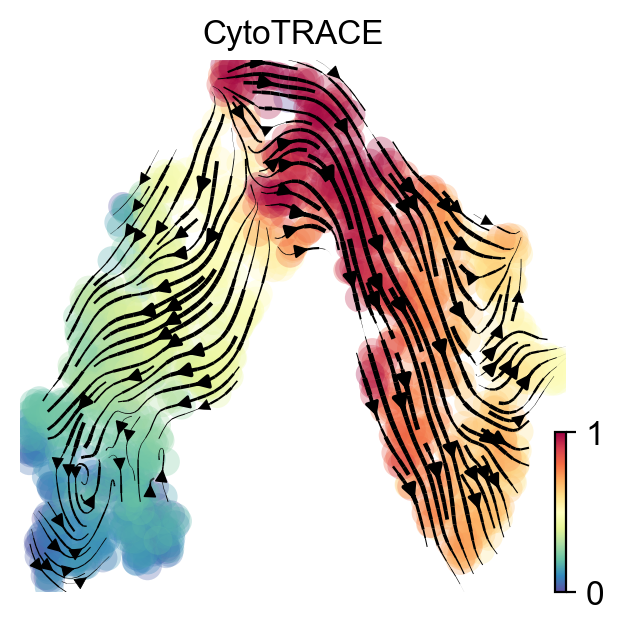

In [8]:
scv.pp.moments(adata, n_pcs=15, n_neighbors=30)
scv.tl.velocity(adata)
scv.tl.recover_dynamics(adata,n_jobs=40)
scv.tl.velocity(adata,mode="dynamical")
scv.tl.velocity_graph(adata)
scv.set_figure_params(figsize=(3.5,3.5))
scv.pl.velocity_embedding_stream(adata, basis='umap',color="CytoTRACE",cmap="Spectral_r")

saving figure to file ./figures/scvelo_velo_cyto.svg


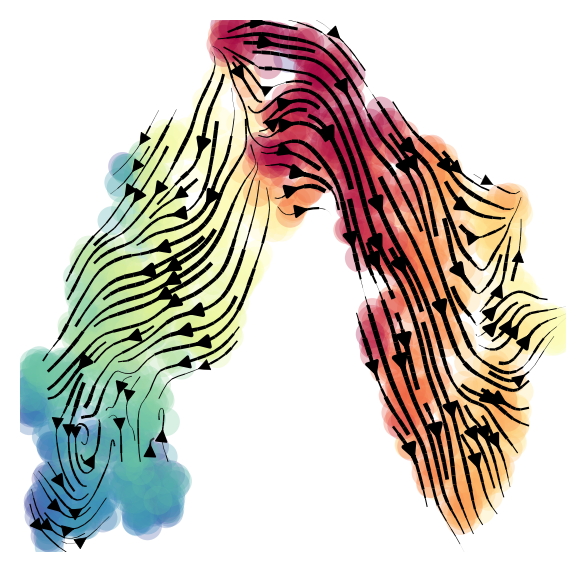

In [9]:
scv.set_figure_params(figsize=(3.5,3.5),dpi_save=600)
scv.pl.velocity_embedding_stream(adata, basis='umap',title="",colorbar=False,color="CytoTRACE",cmap="Spectral_r",save="velo_cyto.svg")

In [10]:
scv.tl.terminal_states(adata,eps=0.01)

computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


In [11]:
scv.tl.recover_latent_time(adata)

computing latent time using root_cells as prior
    finished (0:00:01) --> added 
    'latent_time', shared time (adata.obs)


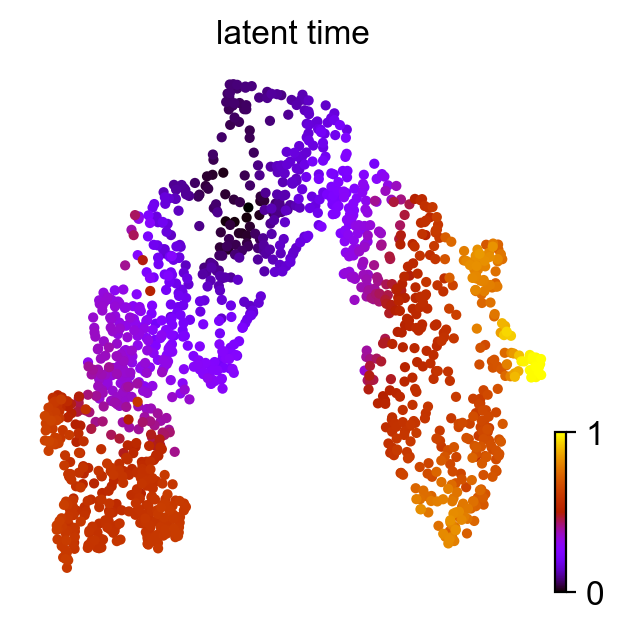

In [12]:
scv.pl.umap(adata,color="latent_time",cmap="gnuplot")

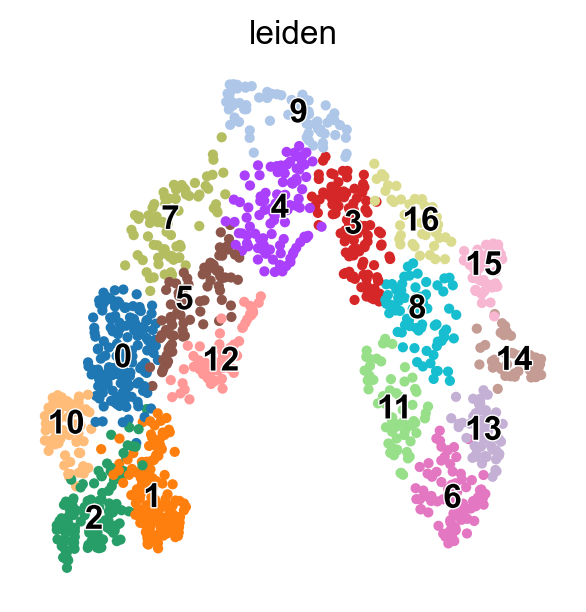

In [13]:
scv.pl.umap(adata,color="leiden")

In [14]:
import cellrank as cr

In [15]:
k = cr.tl.transition_matrix(
    adata, weight_connectivities=0.3, show_progress_bar=False
)
g = cr.tl.estimators.GPCCA(k)

<ipython-input-15-c0e537377ec4>:1: DeprecationWarning: `cellrank.tl.transition_matrix` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  k = cr.tl.transition_matrix(


In [16]:
g.compute_schur(n_components=20)
g.compute_macrostates(n_states=5,cluster_key="leiden",n_cells=15)

In [17]:
g.set_terminal_states_from_macrostates(["1","15","14"],n_cells=15)

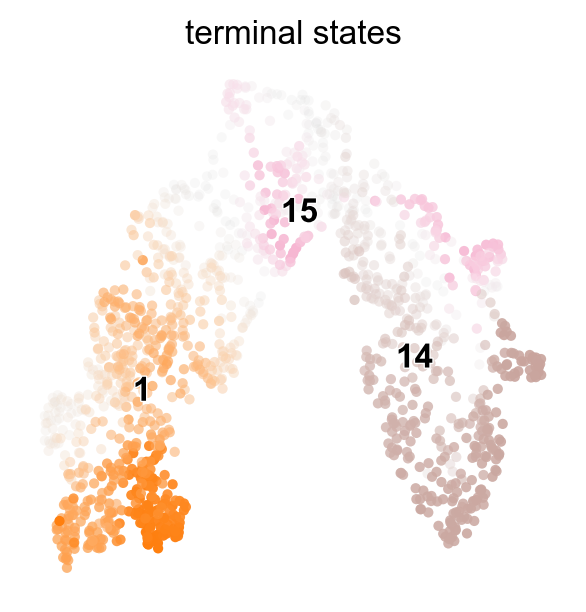

In [18]:
cr.pl.terminal_states(adata)

In [19]:
g.compute_absorption_probabilities()

Defaulting to `'gmres'` solver.


/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/3 [00:00<?, ?/s]

saving figure to file ./figures/scvelo_CR_abs.svg


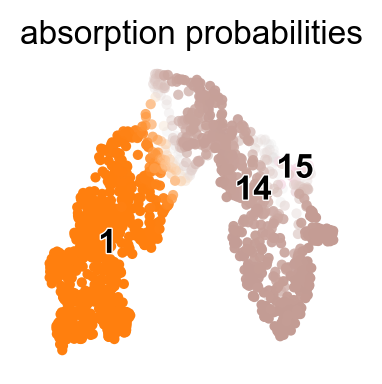

In [20]:
import cellrank as cr
scv.set_figure_params(dpi_save=600,figsize=(2,2))
cr.pl.lineages(adata,save="CR_abs.svg")

In [21]:
adata.obs.terminal_states

/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


SS2_19_346:H18      NaN
SS2_19_346:N7       NaN
SS2_16_249-2:F11    NaN
SS2_19_360:A7       NaN
SS2_16_249-2:K13    NaN
                   ... 
SS2_19_362:L5       NaN
SS2_19_348:A9       NaN
SS2_19_342:G5       NaN
SS2_16_249-2:O20    NaN
SS2_19_344:N17      NaN
Name: terminal_states, Length: 1361, dtype: category
Categories (3, object): ['1', '15', '14']

In [22]:
adata.obsm["terminal_states_memberships"][["15","14"]]

Lineage([[0.04772155, 0.05468939],
         [0.51380962, 0.43833539],
         [0.60613991, 0.33033747],
         ...,
         [0.0203593 , 0.09047604],
         [0.24718097, 0.73274085],
         [0.74699217, 0.18201183]],
  names([15, 14]))

In [23]:
import numpy as np
prob=np.array(adata.obsm["terminal_states_memberships"][["15","14"]])

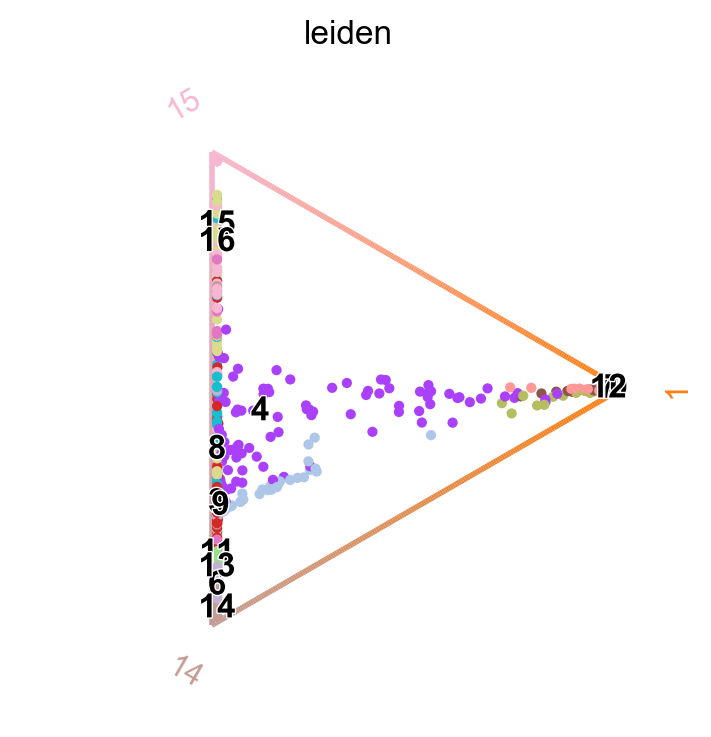

In [24]:
cr.pl.circular_projection(adata,"leiden")

In [25]:
adata.obsm

/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AxisArrays with keys: X_pca, X_umap, velocity_umap, schur_vectors_fwd, terminal_states_memberships, to_terminal_states, X_fate_simplex_fwd

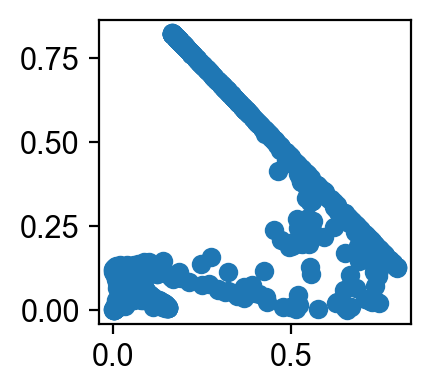

In [26]:
import matplotlib.pyplot as plt
plt.scatter(prob[:,0],prob[:,1])

/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


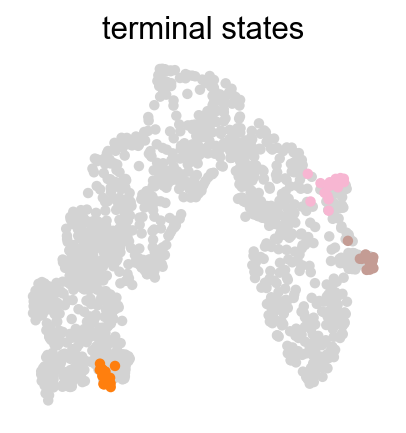

In [27]:
sc.set_figure_params(dpi_save=300,frameon=False,figsize=(3,3))
sc.pl.umap(adata,color="terminal_states",save="terminal_states.svg",title="terminal states",legend_loc="none")

In [28]:
adata=adata.raw.to_adata()
sc.pp.normalize_total(adata,target_sum=1e6)
sc.pp.log1p(adata,base=10)

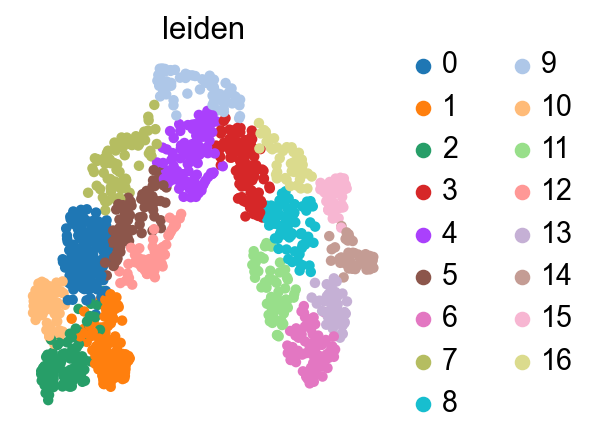

In [29]:
sc.pl.umap(adata,color="leiden")

In [30]:
import numpy as np
np.random.choice(adata.uns["leiden_colors"],len(adata.uns["leiden_colors"]),False)

array(['#c5b0d5', '#279e68', '#e377c2', '#1f77b4', '#f7b6d2', '#98df8a',
       '#ff7f0e', '#aec7e8', '#ff9896', '#ffbb78', '#d62728', '#c49c94',
       '#17becf', '#aa40fc', '#dbdb8d', '#b5bd61', '#8c564b'],
      dtype=object)

In [31]:
adata.uns["leiden_colors"]=np.array(['#98df8a', '#8c564b', '#dbdb8d', '#ff9896', '#ff7f0e', '#279e68',
       '#17becf', '#e377c2', '#c49c94', '#ffbb78', '#b5bd61',
       '#c5b0d5', '#f7b6d2', '#aec7e8','#d62728', '#1f77b4','#aa40fc'],
      dtype=object)

In [32]:
adata.uns["terminal_states_colors"]=adata.uns["leiden_colors"][adata.obs.terminal_states.cat.categories.astype(int)]

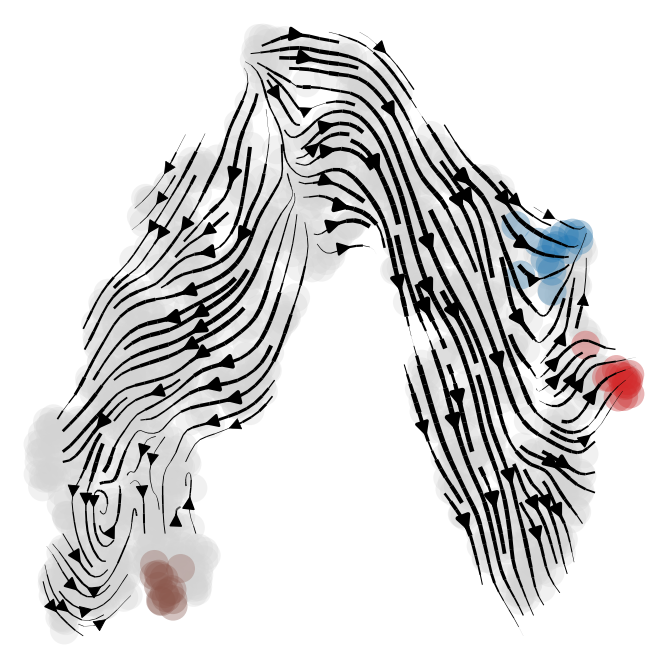

In [33]:
scv.set_figure_params(figsize=(3.5,3.5),dpi_save=600)
ax=scv.pl.velocity_embedding_stream(adata, basis='umap',title="",legend_loc="none",colorbar=False,color="terminal_states",show=False)
padx=-(np.diff(ax.get_xlim())/50)[0],(np.diff(ax.get_xlim())/50)[0]
pady=-(np.diff(ax.get_ylim())/50)[0],(np.diff(ax.get_ylim())/50)[0]
ax.set_xlim(np.array(ax.get_xlim())+np.array(padx));
ax.set_ylim(np.array(ax.get_ylim())+np.array(pady));
plt.tight_layout()
plt.savefig("figures/terminal.pdf")

/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


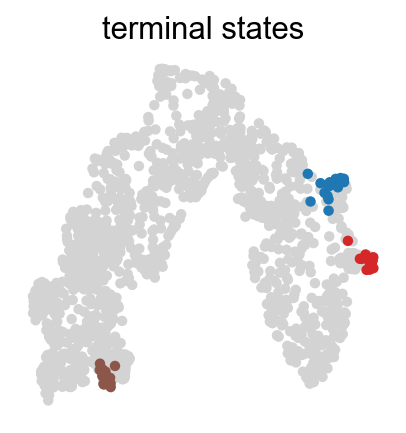

In [34]:
sc.set_figure_params(dpi_save=300,frameon=False,figsize=(3,3))
sc.pl.umap(adata,color="terminal_states",save="terminal_states.pdf",title="terminal states",legend_loc="none")

In [35]:
adata_term=adata[adata.obs.terminal_states.isin(["14","15"])]

/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
sc.tl.rank_genes_groups(adata_term,"terminal_states")

Trying to set attribute `.uns` of view, copying.


/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2503: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  pl.colorbar(mappable, cax=heatmap_cbar_ax)


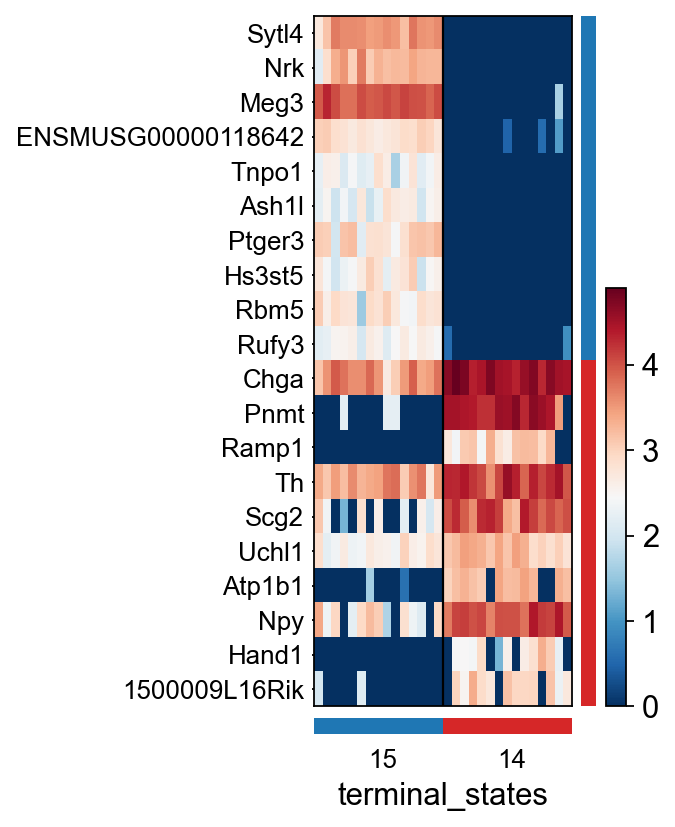

In [37]:
sc.pl.rank_genes_groups_heatmap(adata_term,dendrogram=False,swap_axes=True,figsize=(2.5,6),save="terminal_heatmap.svg")

In [38]:
import scFates as scf

In [39]:
scf.tl.cellrank_to_tree(adata,"latent_time",300,seed=1,ppt_sigma=.1,ppt_lambda=100,
                        reassign_pseudotime=True,auto_root=True,
                        root_params=dict(min_val=True,tips_only=False))

Converting CellRank results to a principal tree --> with .obsm['X_fates'], created by combining:
    .obsm['X_fate_simplex_fwd'] (from cr.pl.circular_projection) and adata.obs['latent_time']

inferring a principal tree inferring a principal tree --> parameters used 
    300 principal points, sigma = 0.1, lambda = 100, metric = euclidean
    fitting:   0%|          | 0/50 [00:00<?, ?it/s]

/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/scvelo/plotting/utils.py:866: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = pl.colorbar(smp, orientation=orientation, cax=cax)


    fitting: 100%|██████████| 50/50 [00:02<00:00, 21.55it/s]
    not converged (error: 0.02385984877053624)
    finished (0:00:02) --> added 
    .uns['ppt'], dictionnary containing inferred tree.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.

auto selecting a tip as a root using latent_time.

automatic root selection using latent_time values
node 297 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.
projecting cells onto the principal graph
    finished (0:00:01) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell 

/home/lfaure/scFates/scFates/tools/pseudotime.py:120: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  milestones = pd.Series(index=adata.obs_names)


/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


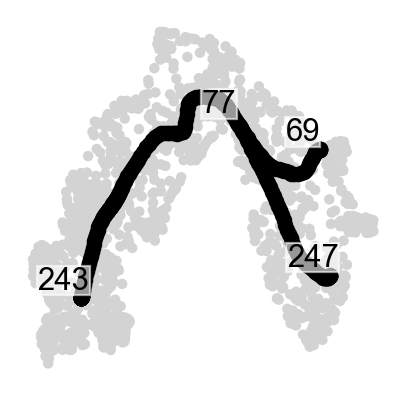

In [40]:
scf.pl.graph(adata)

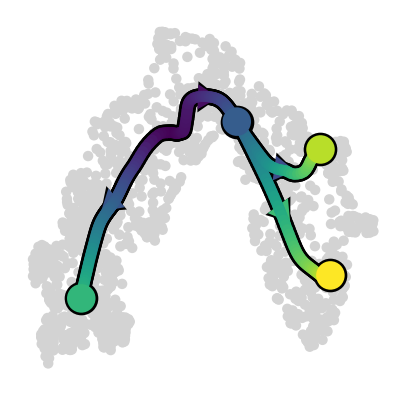

In [41]:
scf.pl.trajectory(adata,arrows=True)

/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


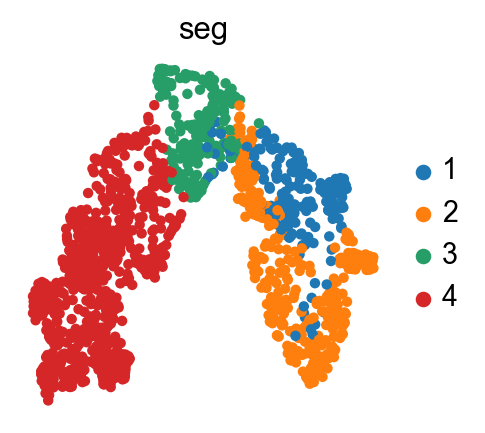

In [42]:
sc.pl.umap(adata,color="seg")

In [43]:
adata_ChC_1=adata[adata.obs.seg=="1"]
adata_ChC_2=adata[adata.obs.seg=="2"]

In [44]:
import pandas as pd
df_1=pd.concat(list(map(lambda i:pd.DataFrame({"devtime":adata_ChC_1.obs.devtime.cat.categories[i],
      "latent time":adata[adata_ChC_1.obs_names][adata_ChC_1.obs.devtime==adata_ChC_1.obs.devtime.cat.categories[i]].obs.t}),
 range(len(adata_ChC_1.obs.devtime.cat.categories)))))

df_2=pd.concat(list(map(lambda i:pd.DataFrame({"devtime":adata_ChC_2.obs.devtime.cat.categories[i],
      "latent time":adata[adata_ChC_2.obs_names][adata_ChC_2.obs.devtime==adata_ChC_2.obs.devtime.cat.categories[i]].obs.t}),
 range(len(adata_ChC_2.obs.devtime.cat.categories)))))

In [46]:
df_2

devtime  latent time
SS2_16_249-2:K13   E12.5     0.560886
SS2_16_249-2:L24   E12.5     0.533683
SS2_16_249-2:I10   E12.5     0.349928
SS2_16_249-2:L15   E12.5     0.731149
SS2_16_249-2:J10   E12.5     0.265615
...                  ...          ...
SS2_19_362:A21        P2     0.977586
SS2_19_360:B3         P2     0.890102
SS2_19_360:D4         P2     0.924696
SS2_19_362:G15        P2     0.990739
SS2_19_360:M2         P2     0.880158

[326 rows x 2 columns]

/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
<ipython-input-48-55017859a371>:9: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False)


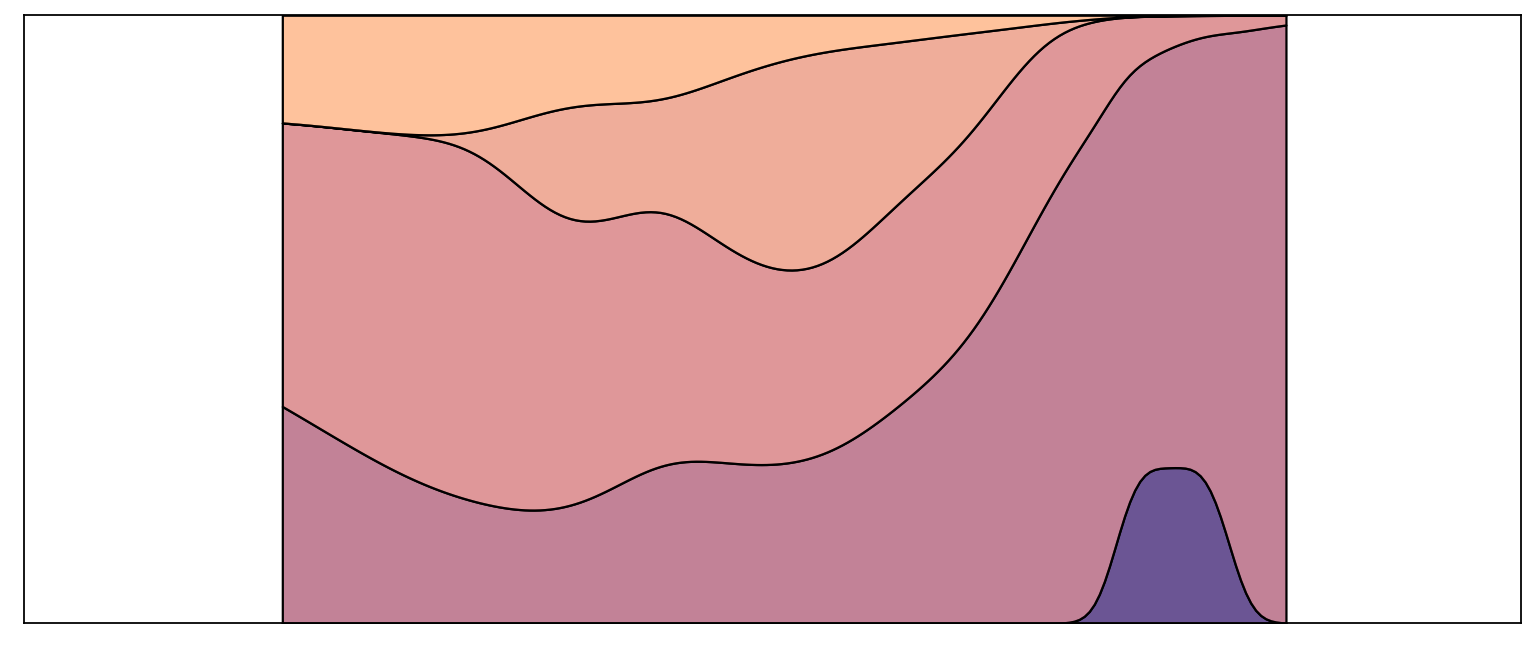

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
sc.set_figure_params(dpi_save=600)
fig, ax1 = plt.subplots(figsize=(12,5))
sns.kdeplot(data=df_1, x="latent time", hue="devtime", multiple="fill",clip= (df_1["latent time"].min(), df_1["latent time"].max()),
           palette=sns.color_palette(adata.uns["devtime_colors"][:4].tolist()+[adata.uns["devtime_colors"][5]]),legend=False,ax=ax1)
#ax1.set_xlim([df_1.pseudotime.min(),adata[adata_ChC_1.obs_names].obs.t.max()])

plt.grid(b=False)
ax1.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)
ax1.set_xlim([0,1])
plt.savefig("figures/ChC_1.png")

/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


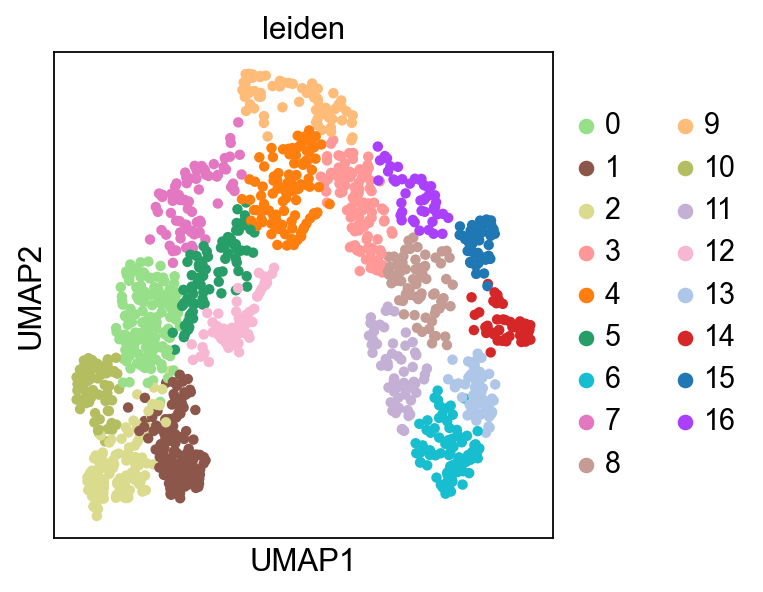

In [49]:
sc.pl.umap(adata,color="leiden")

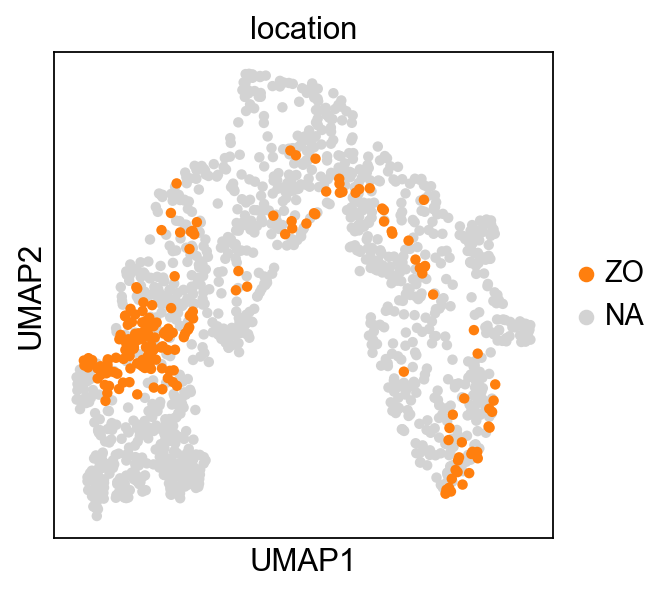

In [50]:
sc.pl.umap(adata,color="location",groups=["ZO"])

/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-51-a311d431a967>:6: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False)


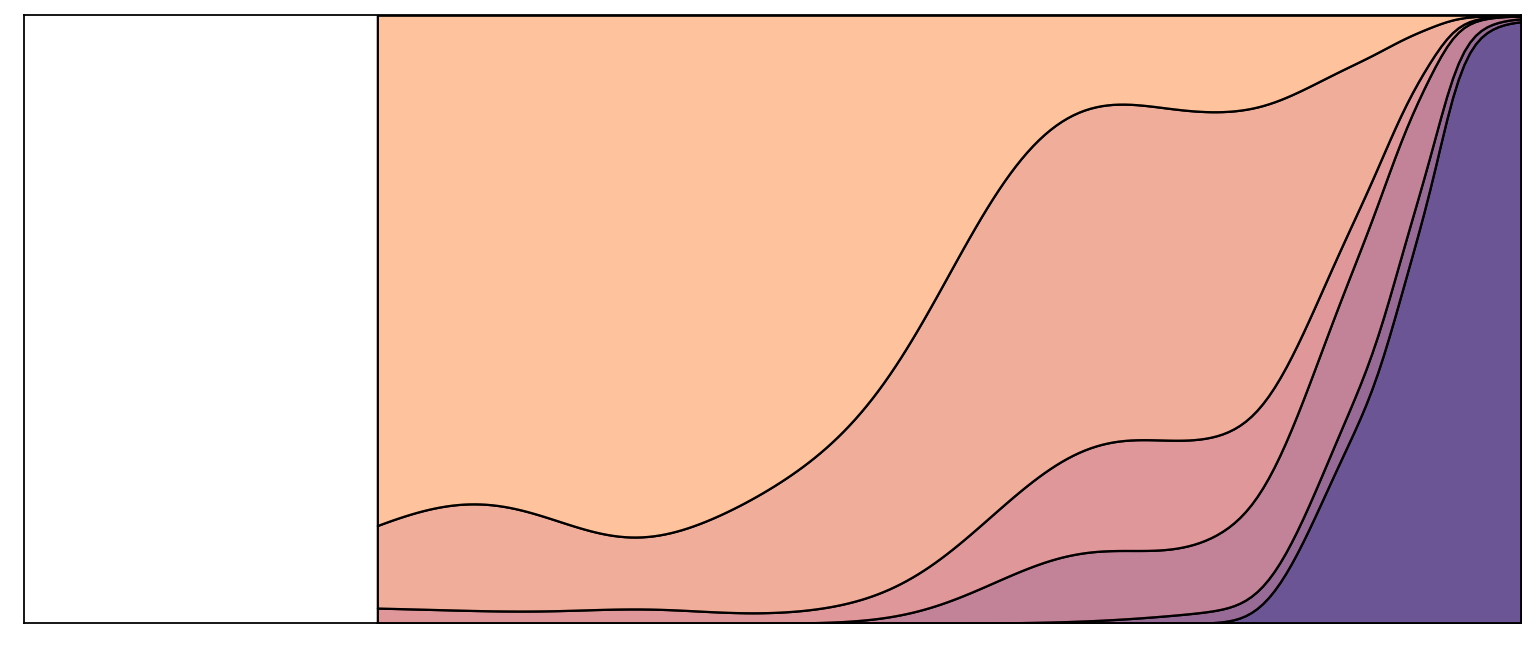

In [51]:

fig, ax2 = plt.subplots(figsize=(12,5))
sns.kdeplot(data=df_2, x="latent time", hue="devtime", multiple="fill",clip= (df_2["latent time"].min(), df_2["latent time"].max()),
           palette=sns.color_palette(adata.uns["devtime_colors"]),legend=False,ax=ax2)
#ax2.set_xlim([df_2.pseudotime.min(),adata[adata_ChC_2.obs_names].obs.t.max()])
ax2.set_xlim([0,1])
plt.grid(b=False)
ax2.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
plt.savefig("figures/ChC_2.png")

/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-53-8f3de945ef96>:8: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False)
<ipython-input-53-8f3de945ef96>:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False)


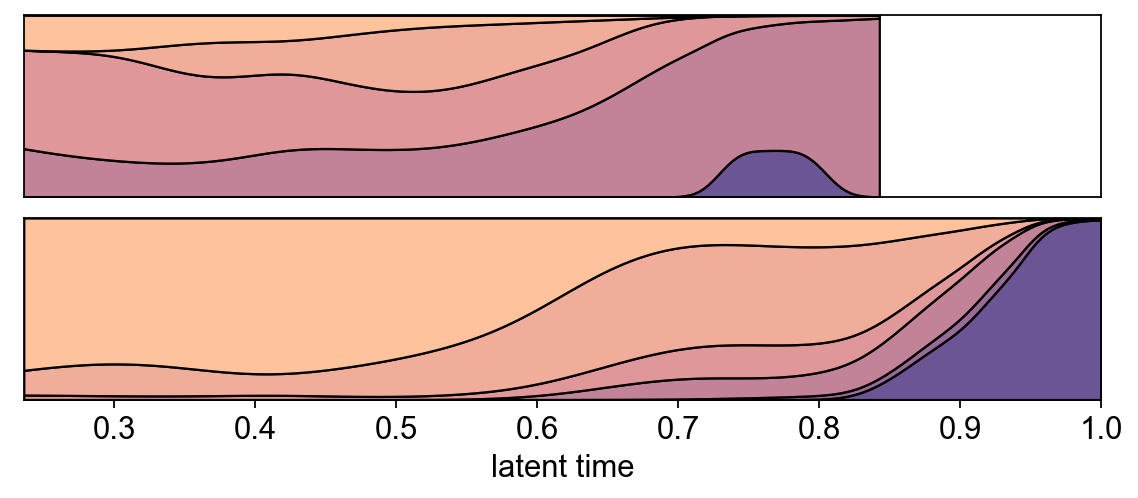

In [53]:
import seaborn as sns
fig, (ax1,ax2) = plt.subplots(figsize=(7,3),nrows=2,ncols=1,sharex=True,constrained_layout=True)

sns.kdeplot(data=df_1, x="latent time", hue="devtime", multiple="fill",clip= (df_1["latent time"].min(), df_1["latent time"].max()),
           palette=sns.color_palette(adata.uns["devtime_colors"][:4].tolist()+[adata.uns["devtime_colors"][5]]),legend=False,ax=ax1)
#ax1.set_xlim([df_1["latent time"].min(),adata[adata_ChC_1.obs_names].obs.t.max()])

plt.grid(b=False)
ax1.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)
ax1.set_xlim([df_2["latent time"].min(),1])

sns.kdeplot(data=df_2, x="latent time", hue="devtime", multiple="fill",clip= (df_2["latent time"].min(), df_2["latent time"].max()),
           palette=sns.color_palette(adata.uns["devtime_colors"]),legend=False,ax=ax2)
#ax2.set_xlim([df_2["latent time"].min(),adata[adata_ChC_2.obs_names].obs.t.max()])
ax2.set_xlim([df_2["latent time"].min(),1])
plt.grid(b=False)
#ax2.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)

plt.savefig("figures/ChC_covnergence.pdf")

In [57]:
del adata.uns["coarse_fwd"]

In [58]:
adata.write("adata_CR_scFates.h5ad")

In [3]:
import matplotlib.pyplot as plt

In [1]:
import scanpy as sc
import scvelo as scv
scv.set_figure_params(figsize=(3.5,3.5),dpi_save=600)
adata=sc.read("adata_CR_scFates.h5ad")

saving figure to file ./figures/scvelo_leiden_1.5.svg


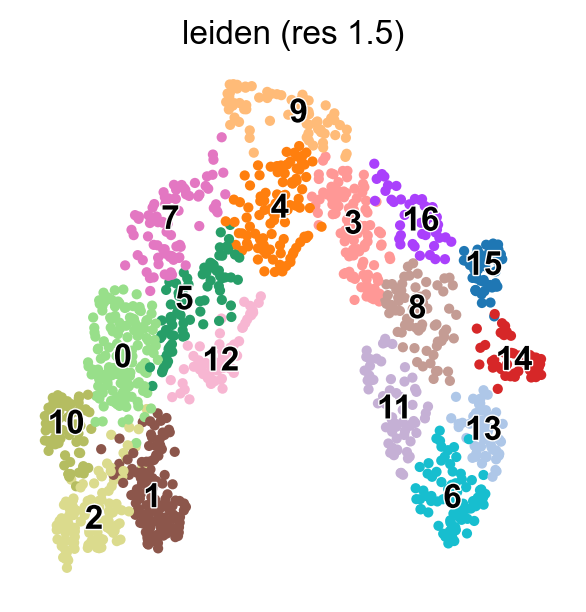

In [4]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Arial']
#sc.set_figure_params(dpi_save=600)
scv.pl.umap(adata,color="leiden",cmap="gnuplot", title="leiden (res 1.5)",save="leiden_1.5.svg")

saving figure to file ./figures/scvelo_latent_time.svg


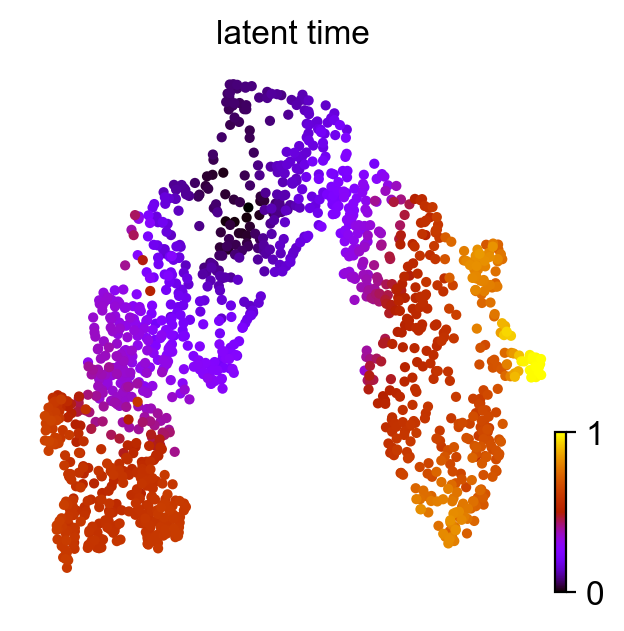

In [5]:
scv.pl.umap(adata,color="latent_time",cmap="gnuplot",save="latent_time.svg")

saving figure to file ./figures/scvelo_cc.svg


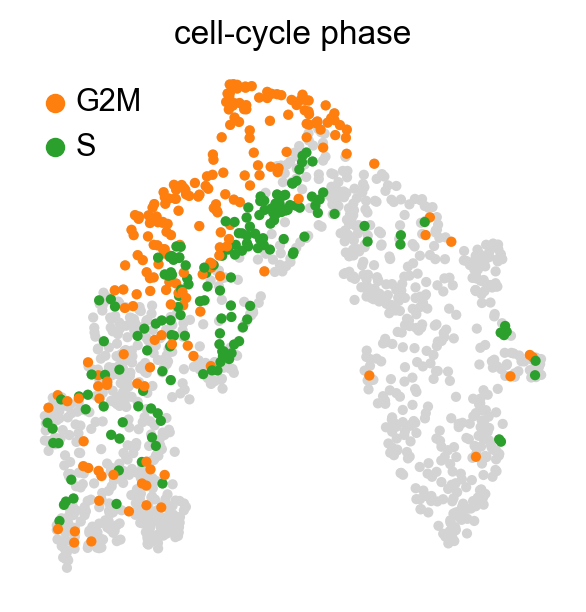

In [6]:
scv.pl.umap(adata,color="phase",groups=["G2M","S"],legend_loc="upper left",title="cell-cycle phase",save="cc.svg")

In [8]:
import scFates as scf

In [81]:
scf.tl.test_association(adata,n_jobs=40)

test features for association with the trajectory
    single mapping : 100%|██████████| 35535/35535 [02:24<00:00, 245.87it/s]
    found 7966 significant features (0:02:24) --> added
    .var['p_val'] values from statistical test.
    .var['fdr'] corrected values from multiple testing.
    .var['st'] proportion of mapping in which feature is significant.
    .var['A'] amplitue of change of tested feature.
    .var['signi'] feature is significantly changing along pseudotime.
    .uns['stat_assoc_list'] list of fitted features on the graph for all mappings.


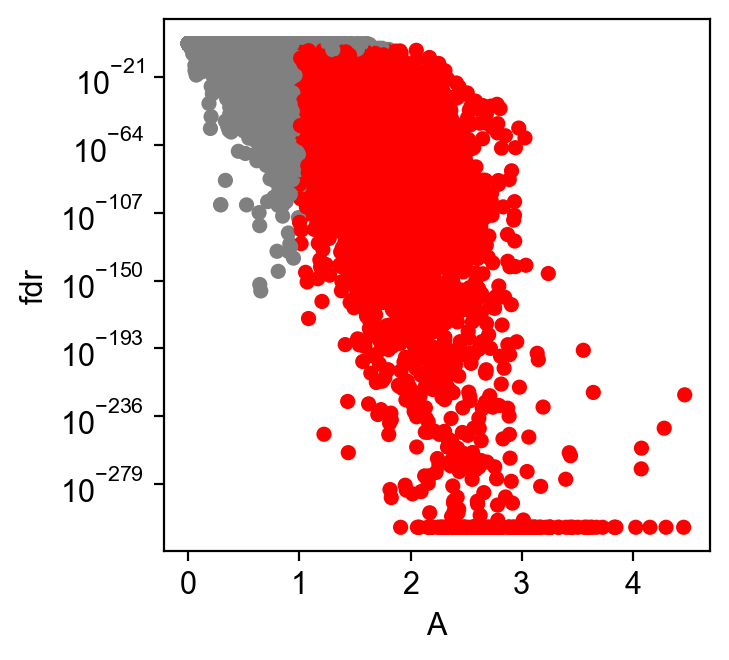

In [82]:
scf.pl.test_association(adata)

In [83]:
scf.tl.fit(adata,n_jobs=40)

fit features associated with the trajectory
    single mapping : 100%|██████████| 7966/7966 [00:45<00:00, 176.17it/s]
    finished (adata subsetted to keep only fitted features!) (0:00:49) --> added
    .layers['fitted'], fitted features on the trajectory for all mappings.
    .raw, unfiltered data.


In [153]:
adata.uns["milestones_colors"]=['#2ca02c', '#d62728', '#ff7f0e','#1f77b4', '#9467bd']

In [93]:
adata.obs.milestones

SS2_16_249-2:A1      77
SS2_16_249-2:A10     77
SS2_16_249-2:A11     77
SS2_16_249-2:A12     77
SS2_16_249-2:A13     77
                   ... 
SS2_19_362:M6       243
SS2_19_362:N6       243
SS2_19_362:N7       243
SS2_19_362:O5       243
SS2_19_362:P11      243
Name: milestones, Length: 1361, dtype: category
Categories (5, object): ['243', '247', '297', '69', '77']

In [94]:
scf.tl.rename_milestones(adata,["SC","ChC 2","progenitors","ChC 1","ChC prog."])

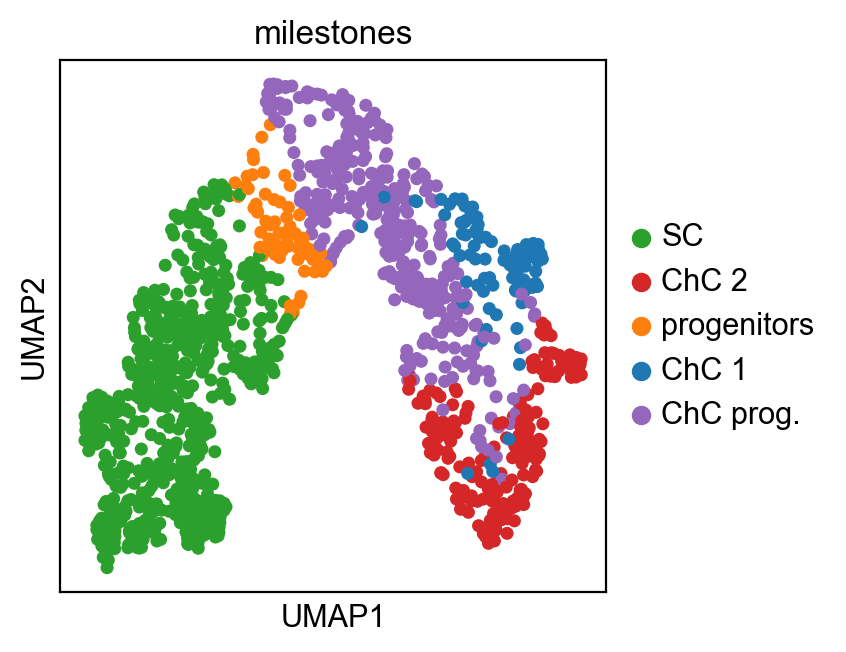

In [154]:
sc.pl.umap(adata,color="milestones")

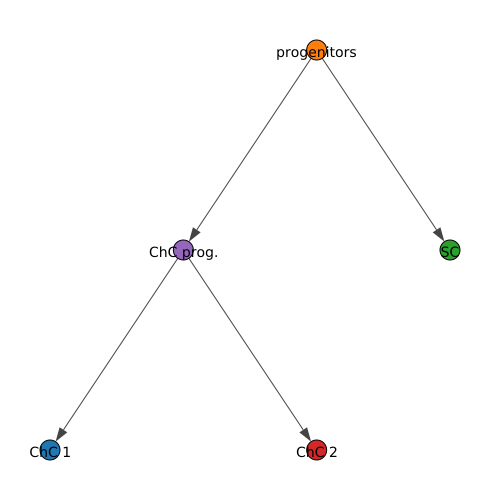

In [9]:
scf.pl.milestones(adata)

In [11]:
root="progenitors"
miles=["ChC 1","ChC 2"]

In [110]:
scf.tl.test_fork(adata,root,miles,n_jobs=40,rescale=True)

testing fork
    single mapping
    Differential expression: 100%|██████████| 7966/7966 [00:15<00:00, 514.55it/s]
    test for upregulation for each leave vs root
    upreg ChC 2: 100%|██████████| 5937/5937 [00:05<00:00, 1008.46it/s]
    finished (0:00:24) --> added 
    .uns['progenitors->ChC 1<>ChC 2']['fork'], DataFrame with fork test results.


In [111]:
scf.tl.branch_specific(adata,root,miles,effect=.5)

    branch specific features: ChC 2: 90, ChC 1: 34
    finished --> updated 
    .uns['progenitors->ChC 1<>ChC 2']['fork'], DataFrame updated with additionnal 'branch' column.


In [106]:
adata.var.index.name=None

In [109]:
adata.var

mito  n_cells_by_counts  mean_counts  pct_dropout_by_counts  \
Mrpl15   False               1980    22.081331              42.691751   
Lypla1   False               1747    14.324747              49.435601   
Atp6v1h  False               2076    41.591316              39.913169   
Rb1cc1   False               2128    25.035601              38.408104   
St18     False                749    17.196815              78.321274   
...        ...                ...          ...                    ...   
Msl3     False               1238    10.679016              64.167873   
Hccs     False               1093    10.787265              68.364689   
Kdm5d    False                994    10.985818              71.230101   
Uty      False               1128     6.957453              67.351664   
Gm47283  False               2016     2.505934              41.649783   

         total_counts  n_cells          p_val         A            fdr  st  \
Mrpl15        76291.0     1946  4.656208e-102  1.932044   1.654584e-97   1   
Lypla1        49492.0     1707   8.215231e-67  1.614598   2.919282e-62   1   
Atp6v1h      143698.0     2025  1.709910e-119  1.893184  6.076167e-115   1   
Rb1cc1        86498.0     2064   3.098946e-23  1.393923   1.101211e-18   1   
St18          59415.0      723   0.000000e+00  2.469317   0.000000e+00   1   
...               ...      ...            ...       ...            ...  ..   
Msl3          36896.0     1214   2.723330e-13  1.437631   9.677352e-09   1   
Hccs          37270.0     1074   2.348289e-14  1.367805   8.344646e-10   1   
Kdm5d         37956.0      967   9.940567e-18  1.038796   3.532381e-13   1   
Uty           24038.0     1039   3.010779e-19  1.193644   1.069880e-14   1   
Gm47283        8658.0     1964   7.863634e-18  1.337987   2.794342e-13   1   

         signi  
Mrpl15    True  
Lypla1    True  
Atp6v1h   True  
Rb1cc1    True  
St18      True  
...        ...  
Msl3      True  
Hccs      True  
Kdm5d     True  
Uty       True  
Gm47283   True  

[7966 rows x 11 columns]

In [119]:
adata_scp=adata[adata.obs.annot=="SCP"]

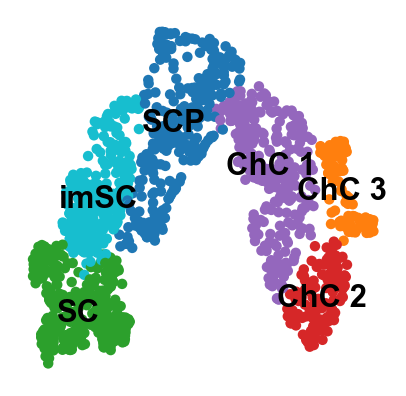

In [123]:
sc.pl.umap(adata,color="annot",frameon=False,legend_loc="on data",title="",save="annot.svg")

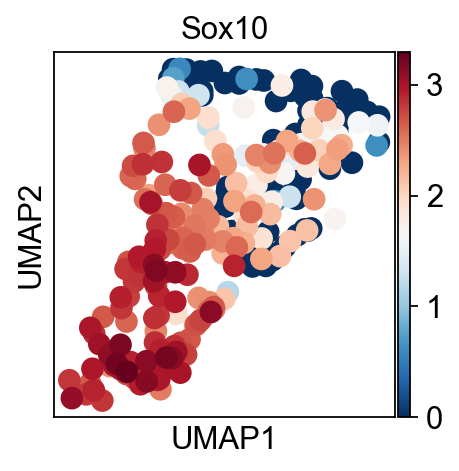

In [120]:
sc.pl.umap(adata_scp,color="Sox10")

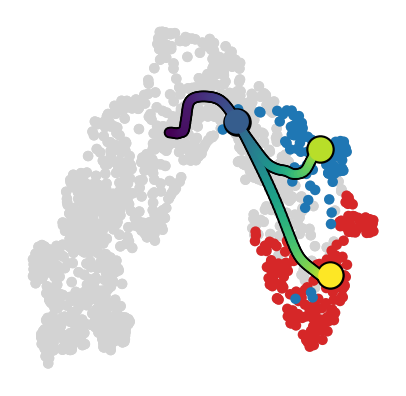

In [155]:
sc.set_figure_params(figsize=(3,3),dpi_save=600)
scf.pl.trajectory(adata,root_milestone="progenitors",title="",milestones=miles,color_cells="milestones",groups=["ChC 1", "ChC 2"],scale_path=.7,
                  frameon=False,legend_loc="none",save="scFates.png")

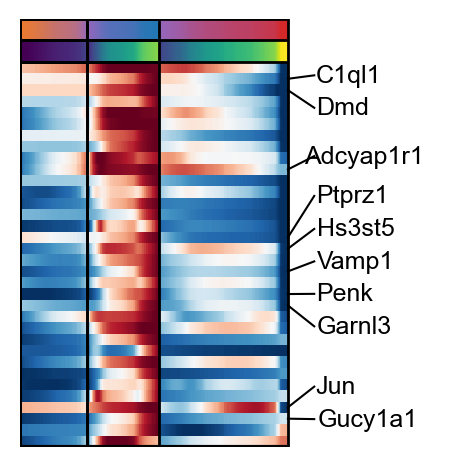

In [12]:
scf.pl.trends(adata,root_milestone=root,milestones=miles,branch="ChC 1",save="ChC_1.svg",annot="milestones",fig_heigth=2.5,plot_emb=False,heatmap_space=.4,offset_names=.1)

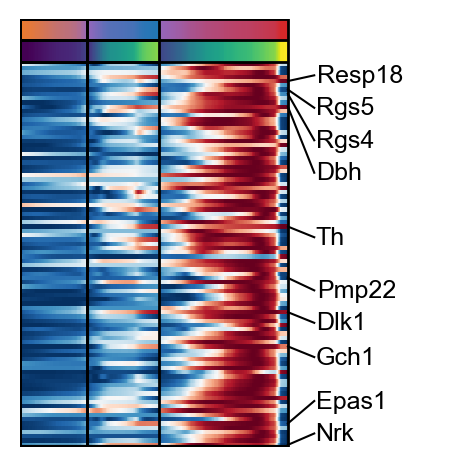

In [13]:
scf.pl.trends(adata,root_milestone=root,milestones=miles,branch="ChC 2",save="ChC_2.svg",
              ordering="maximum",annot="milestones",fig_heigth=2.5,plot_emb=False,heatmap_space=.4,offset_names=.1)

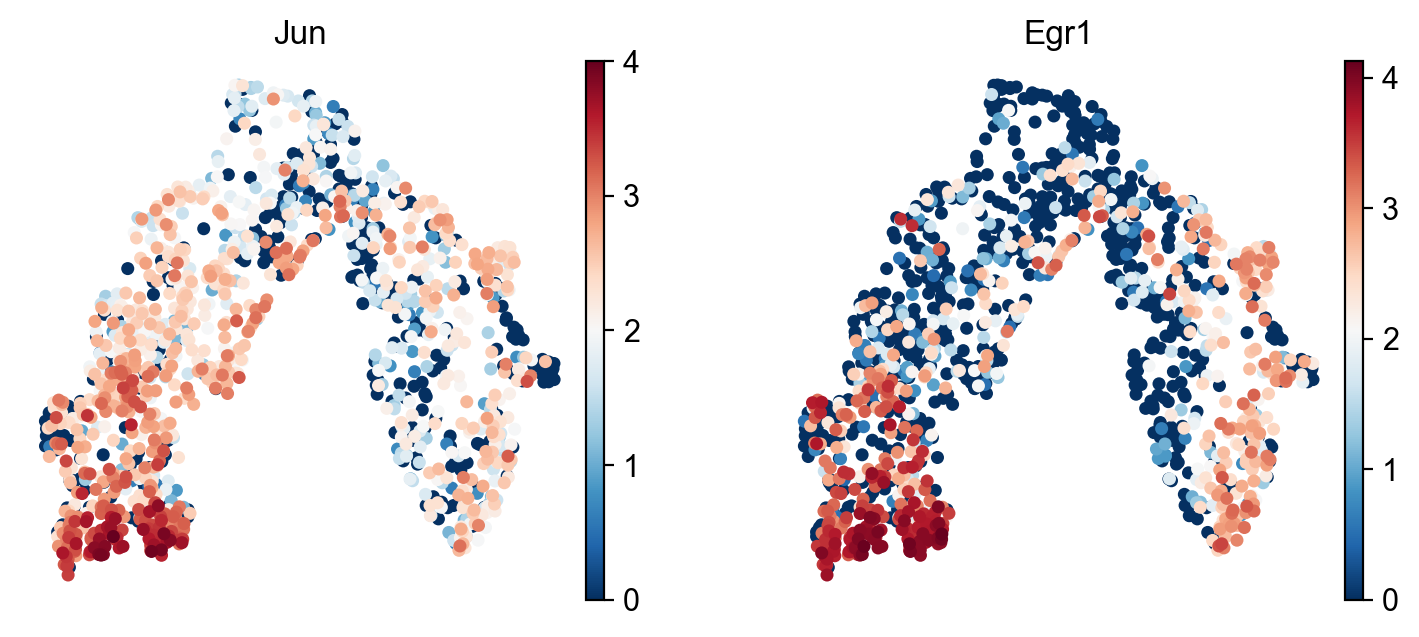

In [102]:
sc.pl.umap(adata,color=["Jun","Egr1"])